In [12]:
import SimpleITK as sitk
import glob
import os
import glob
import lpips
import torch
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt

In [2]:
manifest = pd.read_excel('/mnt/data/home/ZC/denoising/Patient_lists/fixedCT_static_shuffled_batched.xlsx', dtype=str)
manifest = manifest[manifest['batch'] == '5']
manifest = manifest[['batch', 'Patient_ID', 'Patient_subID']].sort_values(by=['Patient_ID', 'Patient_subID'])
manifest

,batch,Patient_ID,Patient_subID
97,5,00010436,0000034479
95,5,00010461,0000455845
99,5,00014689,0000455416
93,5,00019591,0000455445
92,5,00035838,0000455369
85,5,00105734,0000455323
89,5,00154137,0000455529
91,5,00174234,0000455725
94,5,00214792,0000455334
88,5,00214836,0000455414


In [3]:
def read_imgs(manifest, input_folder, filename):
    filenames = []
    for _, row in manifest.iterrows():
        filenames.append(os.path.join(input_folder, row['Patient_ID'], row['Patient_subID'], filename))

    imgs = []

    for i, filename in enumerate(filenames):
        print(i, end=', ', flush=True)
        imgs.append(sitk.GetArrayFromImage(sitk.ReadImage(filename)))

    imgs = np.array(imgs)

    return imgs

In [4]:
def calc_mae_with_cut_off(imgs1, imgs2, vmin, vmax):
    mae_volumes = []

    for img1, img2 in zip(imgs1, imgs2):
        maes = []
        for slice1, slice2 in zip(img1, img2):
            mae = np.mean(np.abs(np.clip(slice1, vmin, vmax) - np.clip(slice2, vmin, vmax)))
            maes.append(mae)
        mae_volumes.append(np.mean(maes))

    return np.mean(mae_volumes), np.std(mae_volumes)

In [5]:
def calc_mae_with_ref_window(imgs, refs, vmin, vmax):
    mae_volumes = []

    for img, ref in zip(imgs, refs):
        maes = []
        for slice_img, slice_ref in zip(img, ref):
            mask = np.where((slice_ref >= vmin) & (slice_ref <= vmax), 1, 0)
            mae = np.sum(np.abs(slice_img - slice_ref) * mask) / np.sum(mask)
            maes.append(mae)
        mae_volumes.append(np.mean(maes))

    return np.mean(mae_volumes), np.std(mae_volumes)

In [6]:
def calc_ssim_with_cut_off(imgs1, imgs2, vmin, vmax):
    ssim_volumes = []
    
    for img1, img2 in zip(imgs1, imgs2):
        ssims = []
        for slice1, slice2 in zip(img1, img2):
            ssim = structural_similarity(np.clip(slice1, vmin, vmax), np.clip(slice2, vmin, vmax), data_range=vmax - vmin)
            ssims.append(ssim)

        ssim_volumes.append(np.mean(ssims))

    return np.mean(ssim_volumes), np.std(ssim_volumes)

In [7]:
def calc_ssim_with_ref_window(imgs, refs, vmin, vmax):
    ssim_volumes = []

    for img, ref in zip(imgs, refs):
        ssims = []
        for slice_img, slice_ref in zip(img, ref):
            mask = np.where((slice_ref >= vmin) & (slice_ref <= vmax), 1, 0)
            _, ssim_map = structural_similarity(slice_img, slice_ref, data_range=vmax - vmin, full=True)
            ssim = np.sum(ssim_map * mask) / np.sum(mask)
            ssims.append(ssim)

        ssim_volumes.append(np.mean(ssims))

    return np.mean(ssim_volumes), np.std(ssim_volumes)

In [8]:
base_dir = '/mnt/data/home/ZC/denoising/models/'

print('Reading ref...', flush=True)
ref_imgs = read_imgs(manifest, os.path.join(base_dir, 'supervised_poisson/pred_images'), 'random_0/epoch58_1/gt_img.nii.gz')

n2n_diff_imgs = {}
for num_test in range(2, 21, 2):
    print(f'Reading noise2noise diffusion with {num_test} test-time samples...', flush=True)
    n2n_diff_imgs[num_test] = read_imgs(
        manifest,
        os.path.join(base_dir, 'unsupervised_gaussian_current_beta0/pred_images'),
        f'random_0/epoch61avg/pred_img_scans{num_test}.nii.gz'
    )


Reading ref...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 2 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 4 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 6 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 8 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 10 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 12 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 14 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion with 16 test-time samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Reading noise2noise diffusion w

In [9]:
def calc_lpips(imgs1, imgs2, vmin, vmax):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    loss_fn = lpips.LPIPS().to(device)
    lpips_volumes = []

    for img1, img2 in zip(imgs1, imgs2):
        lpipss = []
        for slice1, slice2 in zip(img1, img2):
            slice1 = np.clip(slice1, vmin, vmax).astype(np.float32)
            slice2 = np.clip(slice2, vmin, vmax).astype(np.float32)

            slice1 = (slice1 - vmin) / (vmax - vmin) * 2 - 1
            slice2 = (slice2 - vmin) / (vmax - vmin) * 2 - 1

            slice1 = np.stack([slice1, slice1, slice1], axis=-1)
            slice2 = np.stack([slice2, slice2, slice2], axis=-1)

            slice1 = np.transpose(slice1, (2, 0, 1))[np.newaxis, ...]
            slice2 = np.transpose(slice2, (2, 0, 1))[np.newaxis, ...]

            slice1 = torch.from_numpy(slice1).to(device)
            slice2 = torch.from_numpy(slice2).to(device)

            lpips_val = loss_fn(slice1, slice2)
            lpipss.append(lpips_val.item())

        lpips_volumes.append(lpipss)

    return np.mean(lpips_volumes), np.std(lpips_volumes)


In [10]:
maes = []
stds = []
num_tests = []
nimgs = len(manifest)

for num_test in n2n_diff_imgs:
    mae, std = calc_mae_with_ref_window(n2n_diff_imgs[num_test], ref_imgs, 0, 100)
    maes.append(mae)
    stds.append(std)
    num_tests.append(num_test)

df_mae = pd.DataFrame({'num_test': num_tests,
    'mae': maes,
    'std': stds
})
df_mae.to_csv('num_inference_mae.csv', index=False)
df_mae

,num_test,mae,std
0,2,4.218388,0.222108
1,4,3.435055,0.227206
2,6,3.124868,0.237314
3,8,2.956593,0.244450
4,10,2.849702,0.249882
5,12,2.775462,0.254523
6,14,2.721295,0.257935
7,16,2.679808,0.260740
8,18,2.647009,0.263005
9,20,2.620209,0.265216


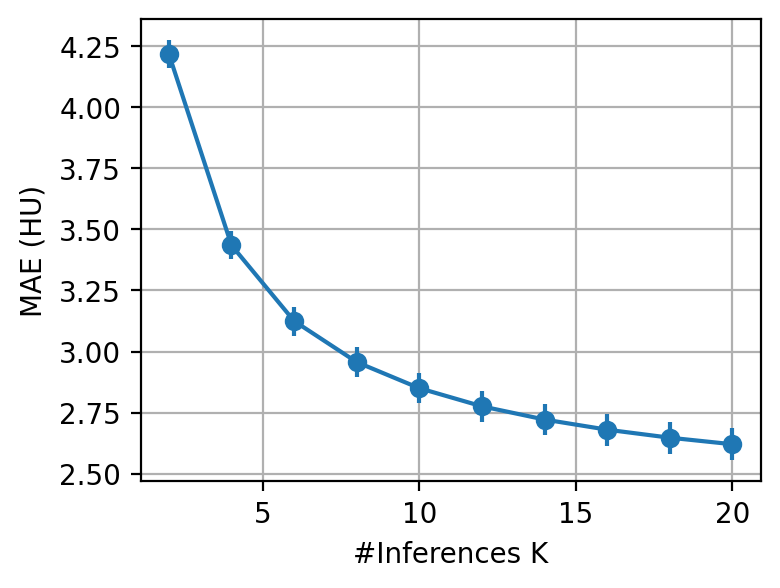

In [16]:
plt.figure(figsize=(4, 3), dpi=200)
plt.errorbar(num_tests, maes, yerr=stds / np.sqrt(nimgs), fmt='-o')
plt.xlabel('#Inferences K')
plt.ylabel('MAE (HU)')
plt.grid()